# FinOpt: Complete Workflow Validation

# Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel
from src.utils import monthly_to_annual

## Mathematical Framework

FinOpt models financial planning under uncertainty via three interconnected modules:

### 1. Income Module
Total monthly income $y_t$ combines fixed and variable streams:

$$y_t = y_t^{\text{fixed}} + y_t^{\text{variable}}$$

**Fixed income** with compounded annual growth $g$ and scheduled raises $\{d_k, \Delta_k\}$:

$$y_t^{\text{fixed}} = \text{current\_salary}(t) \cdot (1+m)^{\Delta t}$$

where $m = (1+g)^{1/12} - 1$ is the monthly rate.

**Variable income** with seasonality $s \in \mathbb{R}^{12}$, noise $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$, and bounds:

$$\tilde{y}_t^{\text{variable}} = \max\Big(0, \min\big(\text{cap}, \max(\text{floor}, \mu_t \cdot (1 + \epsilon_t))\big)\Big)$$

where $\mu_t = \text{base} \cdot (1+m)^t \cdot s_{(t \bmod 12)}$.

**Monthly contributions** via rotative 12-month fractions $\alpha^{f}, \alpha^{v} \in [0,1]^{12}$:

$$A_t = \alpha_{(t+\text{offset}) \bmod 12}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t+\text{offset}) \bmod 12}^{v} \cdot y_t^{\text{variable}}$$

## Configuration: Seasonality and Contribution

In [2]:
# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---
seasonality_variable = [
    0.00,  # Jan: off-season
    0.00,  # Feb: off-season
    0.00,  # Mar: off-season
    1.32,  # Apr: peak starts
    1.32,  # May: peak continues
    1.36,  # Jun: peak maximum
    1.24,  # Jul: peak declining
    1.10,  # Aug: transition
    0.50,  # Sep: low activity
    0.90,  # Oct: recovery
    1.00,  # Nov: baseline
    1.31,  # Dec: year-end boost
]

# --- Annual contribution fractions for fixed income (12 months) ---
monthly_contrib_fixed = [
    0.20,  # Jan
    0.20,  # Feb
    0.20,  # Mar
    0.22,  # Apr: slightly higher
    0.25,  # May: peak contribution
    0.25,  # Jun: peak contribution
    0.23,  # Jul
    0.23,  # Aug
    0.20,  # Sep: reduced (holidays)
    0.20,  # Oct
    0.20,  # Nov
    0.10,  # Dec: reduced (Christmas)
]

# Verify lengths
assert len(seasonality_variable) == 12, "Seasonality must have 12 elements"
assert len(monthly_contrib_fixed) == 12, "Contribution fractions must have 12 elements"
print("Configuration validated ✓")

Configuration validated ✓


## IncomeModel Instantiation

In [3]:
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # CLP/month
        annual_growth=0.05,     # 5% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # +400k in April 2026
            date(2027, 4, 1): 400_000   # +400k in April 2027
        },
        name="fixed"
    ),
    variable=VariableIncome(
        base=150_000.0,         # Base variable income
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly noise
        floor=0.0,              # No negative income
        cap=400_000.0,          # Maximum 400k/month
        annual_growth=0.0,      # No growth in variable
        seed=42,                # Reproducibility
        name="variable"
    ),
)

# --- Define contribution strategy ---
income.monthly_contribution = {
    "fixed": monthly_contrib_fixed,  # Custom monthly fractions
    "variable": [1.0] * 12,          # 100% of variable income
}

print(f"IncomeModel created: {income.fixed.name} + {income.variable.name}")

IncomeModel created: fixed + variable


## Income Visualization

Dual-axis plot with:
- **Left axis**: Fixed income (deterministic) + Total income
- **Right axis**: Variable income (stochastic with trajectories)
- **Trajectories**: Individual noise realizations (n=300)
- **Confidence band**: 95% CI for variable income

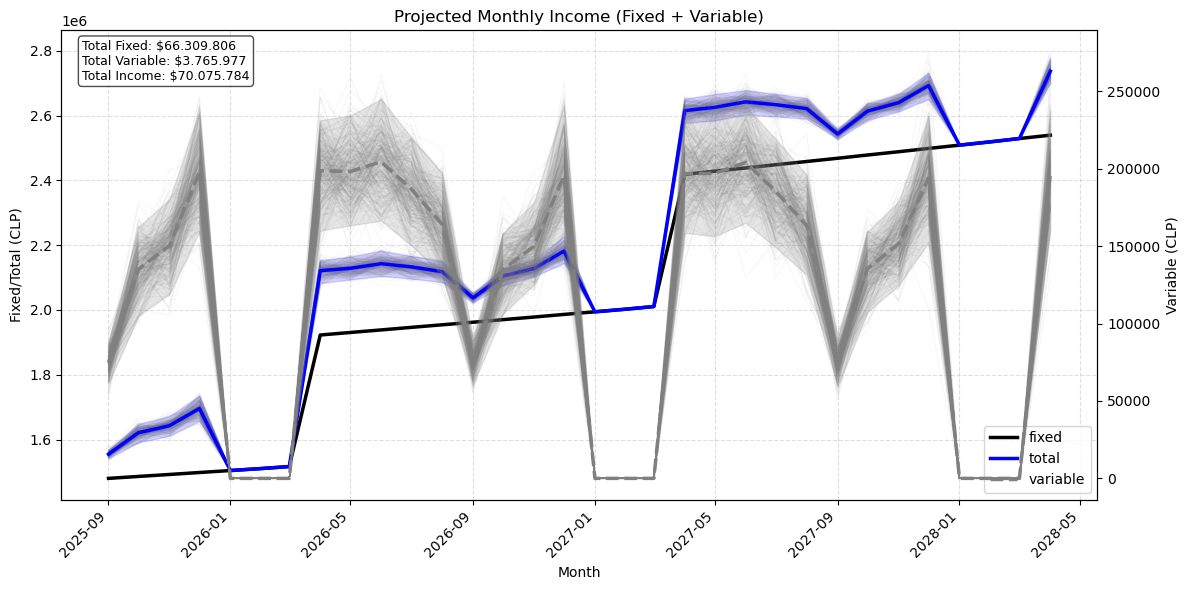

In [4]:
# ==============================
# Income Projection Simulation
# ==============================

# --- Simulation parameters ---
months = 32
start_date = date(2025, 9, 1)

# Custom colors
plot_colors = {
    "fixed": "black",
    "variable": "gray",
    "total": "blue"
}

# Generate plot
fig, ax = income.plot(
    mode="income",
    months=months,
    start=start_date,
    dual_axis=True,
    title="Projected Monthly Income (Fixed + Variable)",
    colors=plot_colors,
    show_trajectories=True,
    trajectory_alpha=0.07,
    show_confidence_band=True,
    n_simulations=300,
    confidence=0.95,
    return_fig_ax=True
)

fig.tight_layout()
plt.show()

## Contribution Projection

Contributions $A_t$ are computed by applying the 12-month fractional arrays to projected incomes, rotated according to `start` date and repeated cyclically for horizons > 12 months.
$$A_t = \alpha_{(t+\text{offset}) \bmod 12}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t+\text{offset}) \bmod 12}^{v} \cdot y_t^{\text{variable}}$$

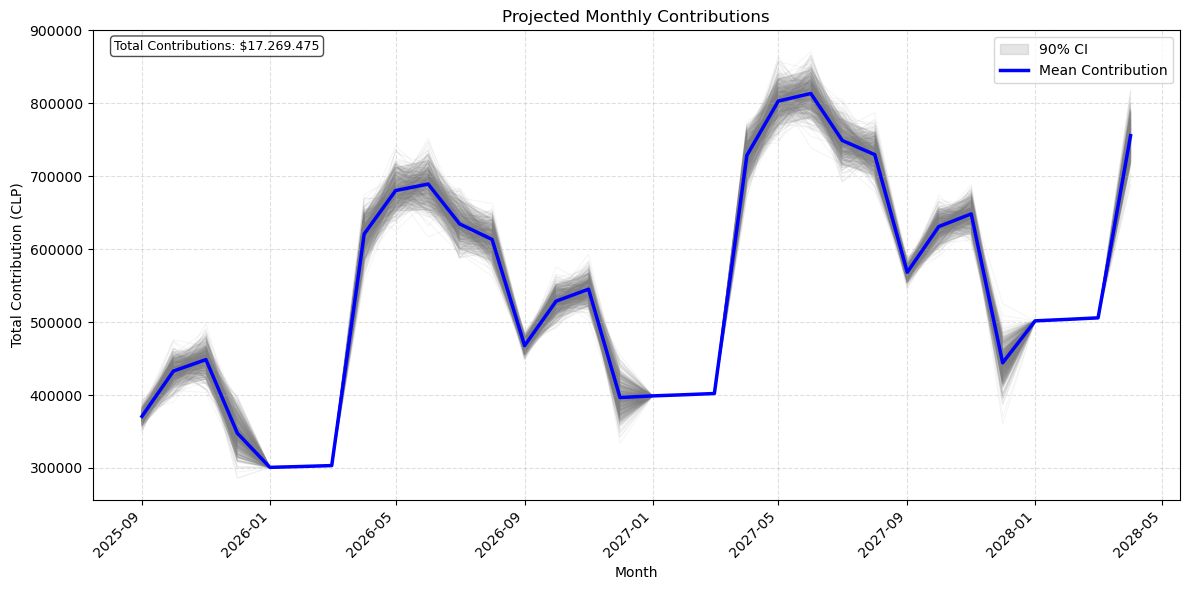

In [5]:
# ==============================
# Contribution Projection Simulation
# ==============================

# Compute contributions (vectorized)
contributions = income.contributions(months=months, start=start_date, seed=42, output="series")

contrib_colors = {
    "total": "blue",
    "ci": "gray" 
}

# --- Generate and display the contributions plot ---
fig, ax = income.plot(
    mode="contributions",
    months=months,
    start=start_date,
    title="Projected Monthly Contributions",
    colors=contrib_colors,
    show_confidence_band=True,
    return_fig_ax=True
)

# Optional: adjust layout for better spacing
fig.tight_layout()

In [6]:
# Summary for 24 months
summary_24m = income.summary(months=32, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                                32.00
total_fixed                     66309806.19
total_variable                   3799321.09
total_income                    70109127.28
mean_fixed                       2072181.44
mean_variable                     118728.78
mean_total                       2190910.23
std_variable                       83757.27
coefvar_variable                       0.71
fixed_share                            0.95
variable_share                         0.05
min_variable                           0.00
max_variable                      214982.10
pct_variable_below_threshold            NaN
dtype: float64


# Return Analysis with Multi-Account Portfolio

## Mathematical Framework

### Multi-Account Return Model

For $M$ accounts with correlated returns:

$$1 + R_t^m \sim \text{LogNormal}(\mu_{\log}^m, \Sigma)$$

where $\Sigma = D \cdot \rho \cdot D$ is the covariance matrix:
- $D = \text{diag}(\sigma_{\log}^1, \ldots, \sigma_{\log}^M)$
- $\rho \in \mathbb{R}^{M \times M}$ is the correlation matrix (symmetric, PSD)
### Cumulative Returns per Account

$$R_{\text{cum}}^m(T) = \prod_{t=0}^{T-1}(1 + R_t^m) - 1$$
**Cross-sectional correlation** persists through time but does not compound.

### Portfolio Design Rationale

Two accounts with different risk-return profiles:
- **Conservative** (Emergency Fund): Low return, low volatility
- **Aggressive** (Growth): High return, high volatility

 **Correlation**: $\rho = 0.3$ (moderate positive correlation, typical for diversified assets)

## Create Multi-Account Portfolio

In [10]:
# ============================================================================
# Account Configuration & ReturnModel Initialization
# ============================================================================

# --- Account configuration: Conservative vs Aggressive ---
accounts = [
    Account.from_annual(
        name="Emergency",
        annual_return=0.04,        # 4% annual (conservative)
        annual_volatility=0.02,    # 2% volatility
        initial_wealth=0
    ),
    Account.from_annual(
        name="Growth",
        annual_return=0.14,        # 14% annual (aggressive)
        annual_volatility=0.15,    # 15% volatility
        initial_wealth=0
    )
]

# --- Correlation matrix (2x2) ---
# Emergency and Growth have moderate positive correlation (ρ = 0.3)
correlation_matrix = np.array([
    [1.0, 0.3],
    [0.3, 1.0]
])

# --- Initialize ReturnModel ---
returns = ReturnModel(accounts, default_correlation=correlation_matrix)

# --- Introspection using new API ---
print(f"🔍 ReturnModel Summary:")
print(returns)  # Uses __repr__ for human-readable output
print(f"\n📊 Parameter Comparison Table:")
print(returns.params_table())
print(f"\n🔗 Correlation Matrix:")
print(correlation_matrix)

# --- Individual account inspection (optional) ---
print(f"\n📈 Individual Account Details:")
for acc in accounts:
    print(f"\n  {acc}")  # Uses Account.__repr__
    print(f"    Monthly:  μ={acc.monthly_params['mu']:.5f}, σ={acc.monthly_params['sigma']:.5f}")
    print(f"    Annual:   μ={acc.annual_params['return']:.2%}, σ={acc.annual_params['volatility']:.2%}")

🔍 ReturnModel Summary:
ReturnModel(M=2, ρ=custom, accounts=['Emergency': 4.0%/year, 'Growth': 14.0%/year])

📊 Parameter Comparison Table:
          μ (monthly) μ (annual) σ (monthly) σ (annual)
Account                                                
Emergency      0.0033      4.00%      0.0058      2.00%
Growth         0.0110     14.00%      0.0433     15.00%

🔗 Correlation Matrix:
[[1.  0.3]
 [0.3 1. ]]

📈 Individual Account Details:

  Account('Emergency': 4.0%/year, σ=2.0%, W₀=$0)
    Monthly:  μ=0.00327, σ=0.00577
    Annual:   μ=4.00%, σ=2.00%

  Account('Growth': 14.0%/year, σ=15.0%, W₀=$0)
    Monthly:  μ=0.01098, σ=0.04330
    Annual:   μ=14.00%, σ=15.00%


## Monthly Return Distribution (Marginal Analysis)

Visualizes IID monthly returns across both accounts with 4 panels:
- **Trajectories**: Individual paths for each account
- **Histograms**: Marginal distributions (overlaid)
- **Correlation**: Sample vs theoretical correlation
- **Statistics**: Mean, std, quantiles per account

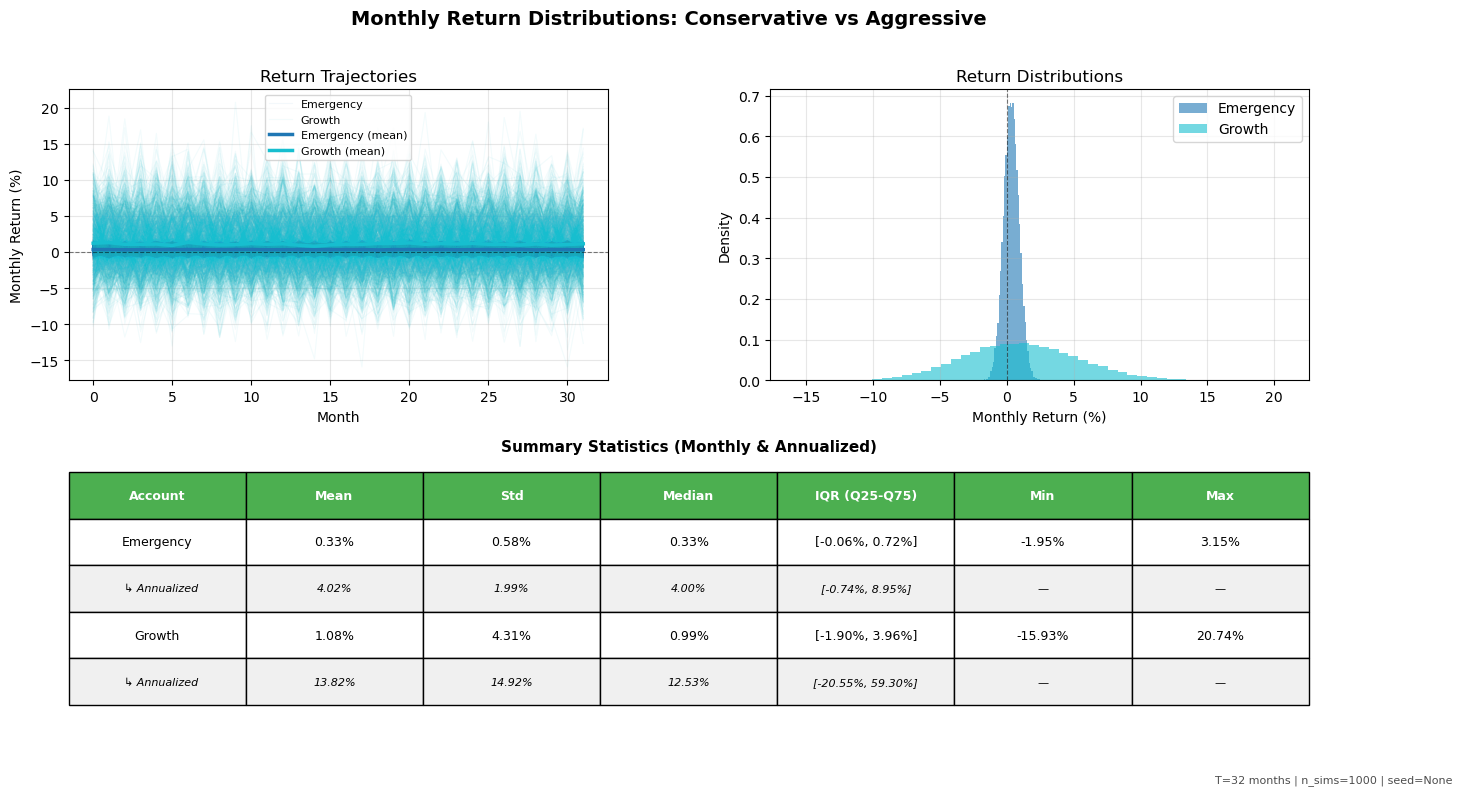

In [11]:
# --- Monthly return analysis ---
returns.plot(
    T=months,                         # 10 years for statistical stability
    n_sims=1000,
    show_trajectories=True,
    trajectory_alpha=0.05,
    title="Monthly Return Distributions: Conservative vs Aggressive"
)

## 3. Cumulative Returns: Path-Dependent Performance

Computes $\prod_{t=0}^{T-1}(1 + R_t^m) - 1$ for each account, showing:
- How compounding affects final distributions
- Divergence between conservative and aggressive strategies
- Final outcome uncertainty per account

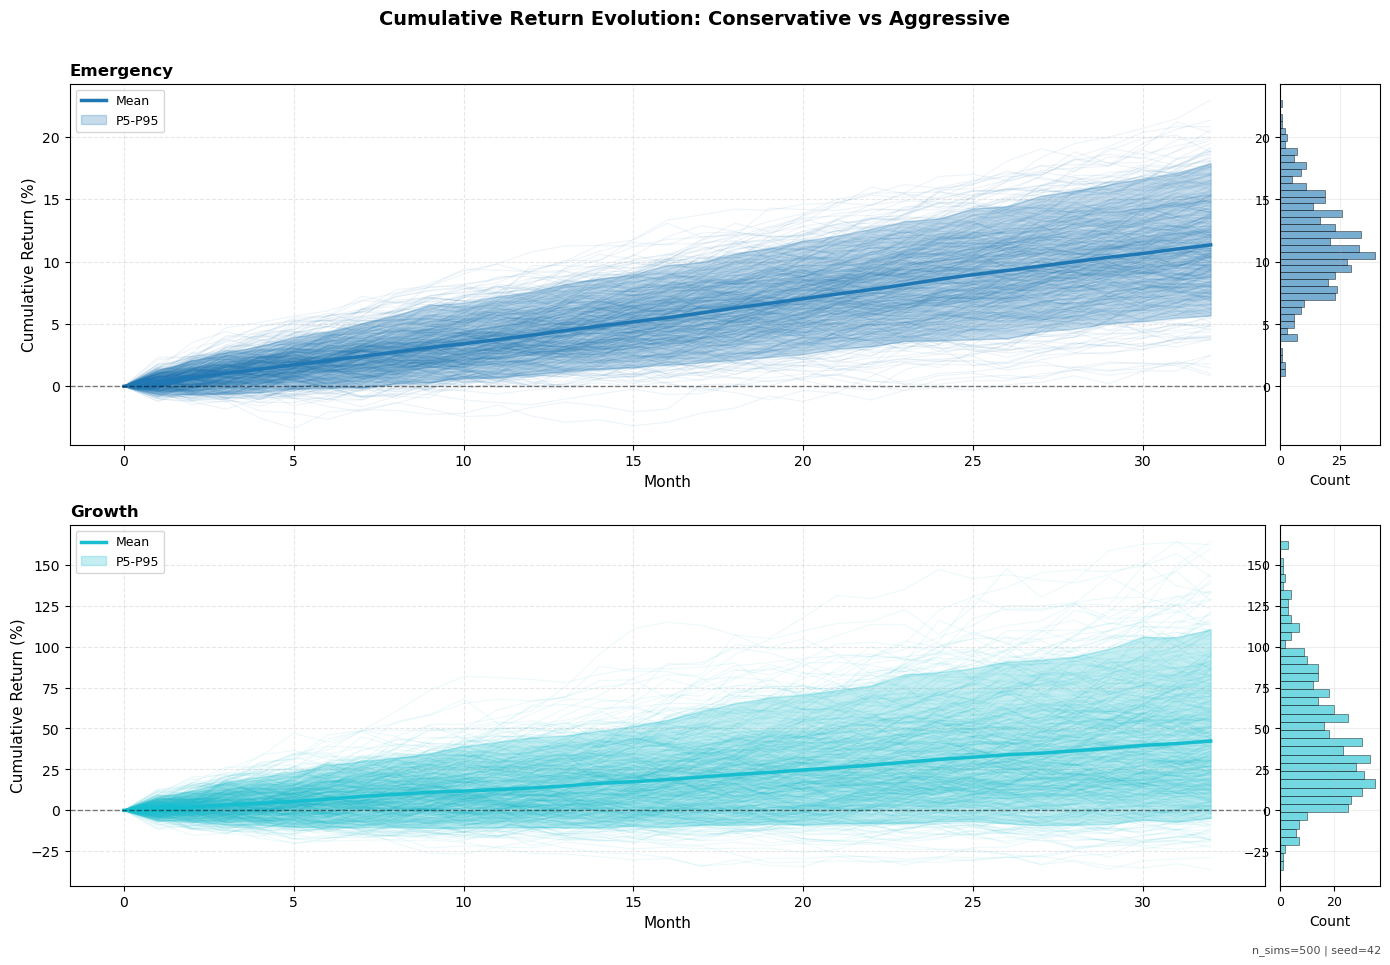

In [12]:
# --- Cumulative returns over 2 years ---
returns.plot_cumulative(
    T=months,                          # 24 months (2 years)
    n_sims=500,
    seed=42,
    show_trajectories=True,
    trajectory_alpha=0.08,
    show_percentiles=True,
    percentiles=(5, 95),
    hist_bins=40,
    title="Cumulative Return Evolution: Conservative vs Aggressive"
)

## Horizon Analysis: Time Diversification by Account


HORIZON ANALYSIS - Emergency
 Horizon |  Expected | Volatility |  P(Loss) |    P25-P75 |    SNR
 (years) |    Return |      (±1σ) |          |      Range |       
-------------------------------------------------------------------------------------
    1.0  |      4.0% |       2.0% |     2.3% |       2.7% |  2.00
    2.0  |      8.2% |       2.8% |     0.2% |       3.8% |  2.88
    3.0  |     12.5% |       3.5% |     0.0% |       4.7% |  3.60
    5.0  |     21.7% |       4.5% |     0.0% |       6.0% |  4.84
   10.0  |     48.0% |       6.3% |     0.0% |       8.5% |  7.59
   20.0  |    119.1% |       8.9% |     0.0% |      12.1% | 13.32

HORIZON ANALYSIS - Growth
 Horizon |  Expected | Volatility |  P(Loss) |    P25-P75 |    SNR
 (years) |    Return |      (±1σ) |          |      Range |       
-------------------------------------------------------------------------------------
    1.0  |     14.0% |      15.0% |    17.5% |      20.2% |  0.93
    2.0  |     30.0% |      21.2% |     7

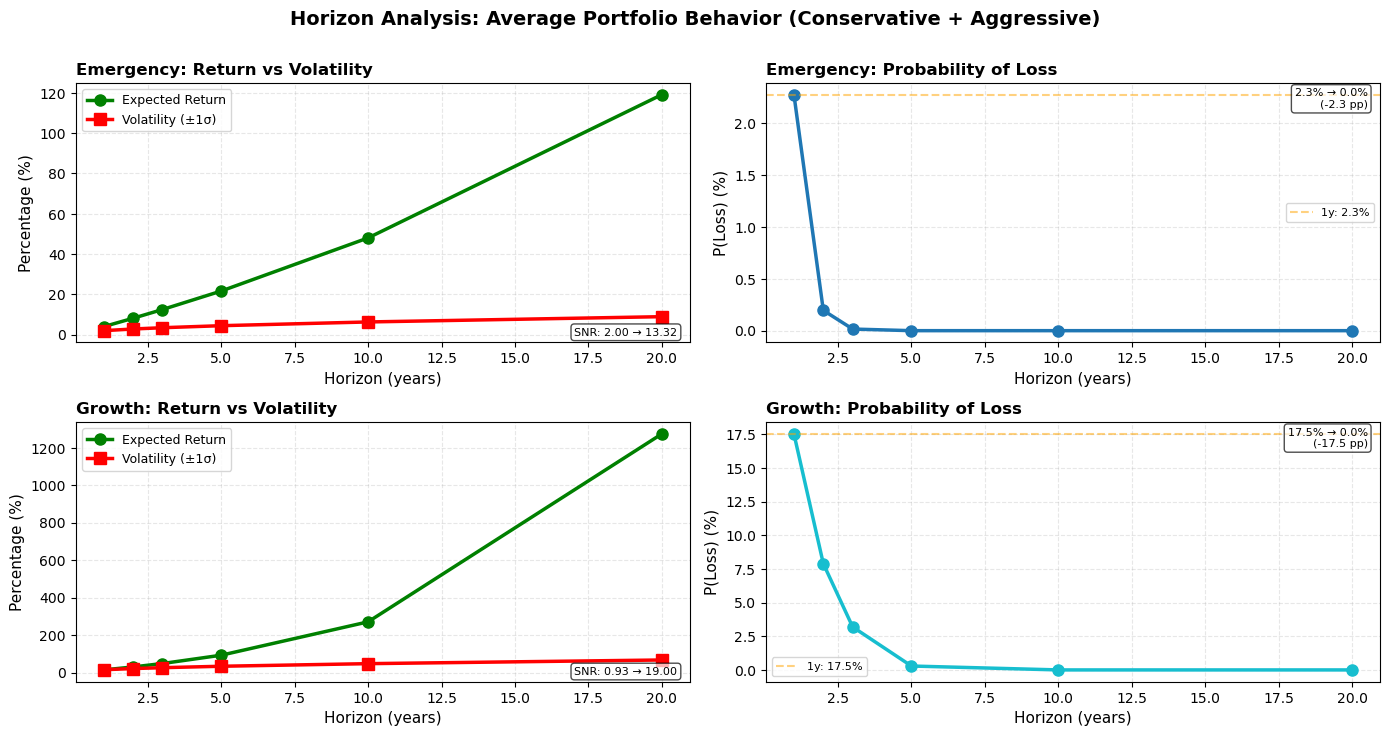

In [13]:
# --- Horizon analysis (average portfolio behavior) ---
returns.plot_horizon_analysis(
    horizons=np.array([1, 2, 3, 5, 10, 20]),
    title="Horizon Analysis: Average Portfolio Behavior (Conservative + Aggressive)",
    show_table=True
)

## Correlation Sensitivity Analysis

In [14]:
from scipy.optimize import minimize

# Scenario 1: Uncorrelated (ρ = 0)
R_uncorr = returns.generate(T=24, n_sims=1000, correlation=np.eye(2), seed=42)

# Scenario 2: Moderate correlation (ρ = 0.3, default)
R_moderate = returns.generate(T=24, n_sims=1000, seed=42)

# Scenario 3: High correlation (ρ = 0.7)
high_corr = np.array([[1.0, 0.7], [0.7, 1.0]])
R_high = returns.generate(T=24, n_sims=1000, correlation=high_corr, seed=42)

print("✓ Simulations generated")

# Pesos 50-50 fijos
X = np.array([0.5, 0.5])

results = {}
for label, rho, R_sims in [
    ("Uncorrelated", 0.0, R_uncorr),
    ("Moderate", 0.3, R_moderate),
    ("High", 0.7, R_high)
]:
    # Portfolio returns: R_p = X₁R₁ + X₂R₂
    R_portfolio = (R_sims * X[None, None, :]).sum(axis=2)  # (n_sims, T)
    
    # Cumulative returns
    cum_gross = np.cumprod(1 + R_portfolio, axis=1)
    final_returns = cum_gross[:, -1] - 1
    
    # Metrics
    mean_return = final_returns.mean()
    vol_return = final_returns.std()
    sharpe = mean_return / vol_return if vol_return > 0 else 0
    cvar_95 = np.percentile(final_returns, 5)
    
    results[label] = {
        "ρ_sample": np.corrcoef(R_sims.reshape(-1, 2).T)[0, 1],
        "E[R_24m]": mean_return * 100,
        "σ[R_24m]": vol_return * 100,
        "Sharpe": sharpe,
        "CVaR_5%": cvar_95 * 100
    }

# Display
import pandas as pd
df = pd.DataFrame(results).T
print("\nDIVERSIFICATION BENEFIT QUANTIFICATION (50-50 Portfolio)")
print("="*70)
print(df.round(3))
print("\nKey insight:")
print(f"  Sharpe ratio degrades {(1 - results['High']['Sharpe']/results['Uncorrelated']['Sharpe'])*100:.1f}% from ρ=0 to ρ=0.7")
print(f"  CVaR worsens {(results['High']['CVaR_5%'] - results['Uncorrelated']['CVaR_5%']):.2f} pp")

✓ Simulations generated

DIVERSIFICATION BENEFIT QUANTIFICATION (50-50 Portfolio)
              ρ_sample  E[R_24m]  σ[R_24m]  Sharpe  CVaR_5%
Uncorrelated     0.003    18.383    12.666   1.451   -0.775
Moderate         0.298    18.369    13.162   1.396   -1.633
High             0.696    18.343    13.802   1.329   -2.200

Key insight:
  Sharpe ratio degrades 8.4% from ρ=0 to ρ=0.7
  CVaR worsens -1.42 pp


In [17]:
# ============================================================================
# Generate Stochastic Inputs (Income + Returns)
# ============================================================================

# --- Simulation parameters ---
n_sims = 500
months = 32  # ~2.5 years
start_date = date(2025, 1, 1)

# --- Income model (from previous cells, assuming it's defined) ---
# Example:
# income = IncomeModel(
#     fixed=FixedIncome(base=1_400_000, annual_growth=0.03),
#     variable=VariableIncome(base=200_000, sigma=0.10)
# )

# --- Generate contributions: shape (n_sims, months) ---
A_sims = income.contributions(
    months=months, 
    start=start_date, 
    seed=42, 
    output="array", 
    n_sims=n_sims
)

# --- Generate returns: shape (n_sims, months, M=2) ---
R_sims = returns.generate(T=months, n_sims=n_sims, seed=42)

# --- Initialize portfolio executor ---
portfolio = Portfolio(accounts)

# --- Verification ---
print(f"✅ Stochastic Inputs Generated:")
print(f"   Contributions (A): {A_sims.shape}")
print(f"   Returns (R):       {R_sims.shape}")
print(f"   Accounts (M):      {portfolio.M}")
print(f"   Horizon (T):       {months} months")
print(f"   Simulations:       {n_sims}")

✅ Stochastic Inputs Generated:
   Contributions (A): (500, 32)
   Returns (R):       (500, 32, 2)
   Accounts (M):      2
   Horizon (T):       32 months
   Simulations:       500


In [18]:
# ============================================================================
# Define Allocation Policy
# ============================================================================

# --- Static allocation: 60% Emergency, 40% Growth ---
X = np.tile([0.6, 0.4], (months, 1))  # shape (months, 2)

# --- Validate policy constraints ---
assert X.shape == (months, 2), f"X shape mismatch: {X.shape}"
assert np.allclose(X.sum(axis=1), 1.0), "X rows must sum to 1"
assert np.all(X >= 0), "X must be non-negative"

print(f"✅ Allocation Policy Validated:")
print(f"   Shape: {X.shape}")
print(f"   Emergency: {X[0, 0]:.0%}")
print(f"   Growth:    {X[0, 1]:.0%}")

✅ Allocation Policy Validated:
   Shape: (32, 2)
   Emergency: 60%
   Growth:    40%


In [19]:
# ============================================================================
# Execute Wealth Dynamics
# ============================================================================

# --- Simulate wealth evolution using AFFINE method (optimization-ready) ---
result = portfolio.simulate(
    A=A_sims, 
    R=R_sims, 
    X=X, 
    method="affine"  # Default: closed-form with analytical gradients
)

# --- Verify result structure ---
print(f"✅ Simulation Complete:")
print(f"   Wealth trajectories: {result['wealth'].shape}")        # (500, 33, 2)
print(f"   Total wealth:        {result['total_wealth'].shape}")  # (500, 33)
print(f"\n📊 Final Wealth Statistics (across simulations):")
final_wealth = result['total_wealth'][:, -1]
print(f"   Mean:   ${final_wealth.mean():,.0f}".replace(",", "."))
print(f"   Median: ${np.median(final_wealth):,.0f}".replace(",", "."))
print(f"   Std:    ${final_wealth.std():,.0f}".replace(",", "."))
print(f"   Min:    ${final_wealth.min():,.0f}".replace(",", "."))
print(f"   Max:    ${final_wealth.max():,.0f}".replace(",", "."))

✅ Simulation Complete:
   Wealth trajectories: (500, 33, 2)
   Total wealth:        (500, 33)

📊 Final Wealth Statistics (across simulations):
   Mean:   $18.309.030
   Median: $18.150.859
   Std:    $1.216.389
   Min:    $15.257.696
   Max:    $23.397.670


/tmp/ipykernel_24816/1294095125.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


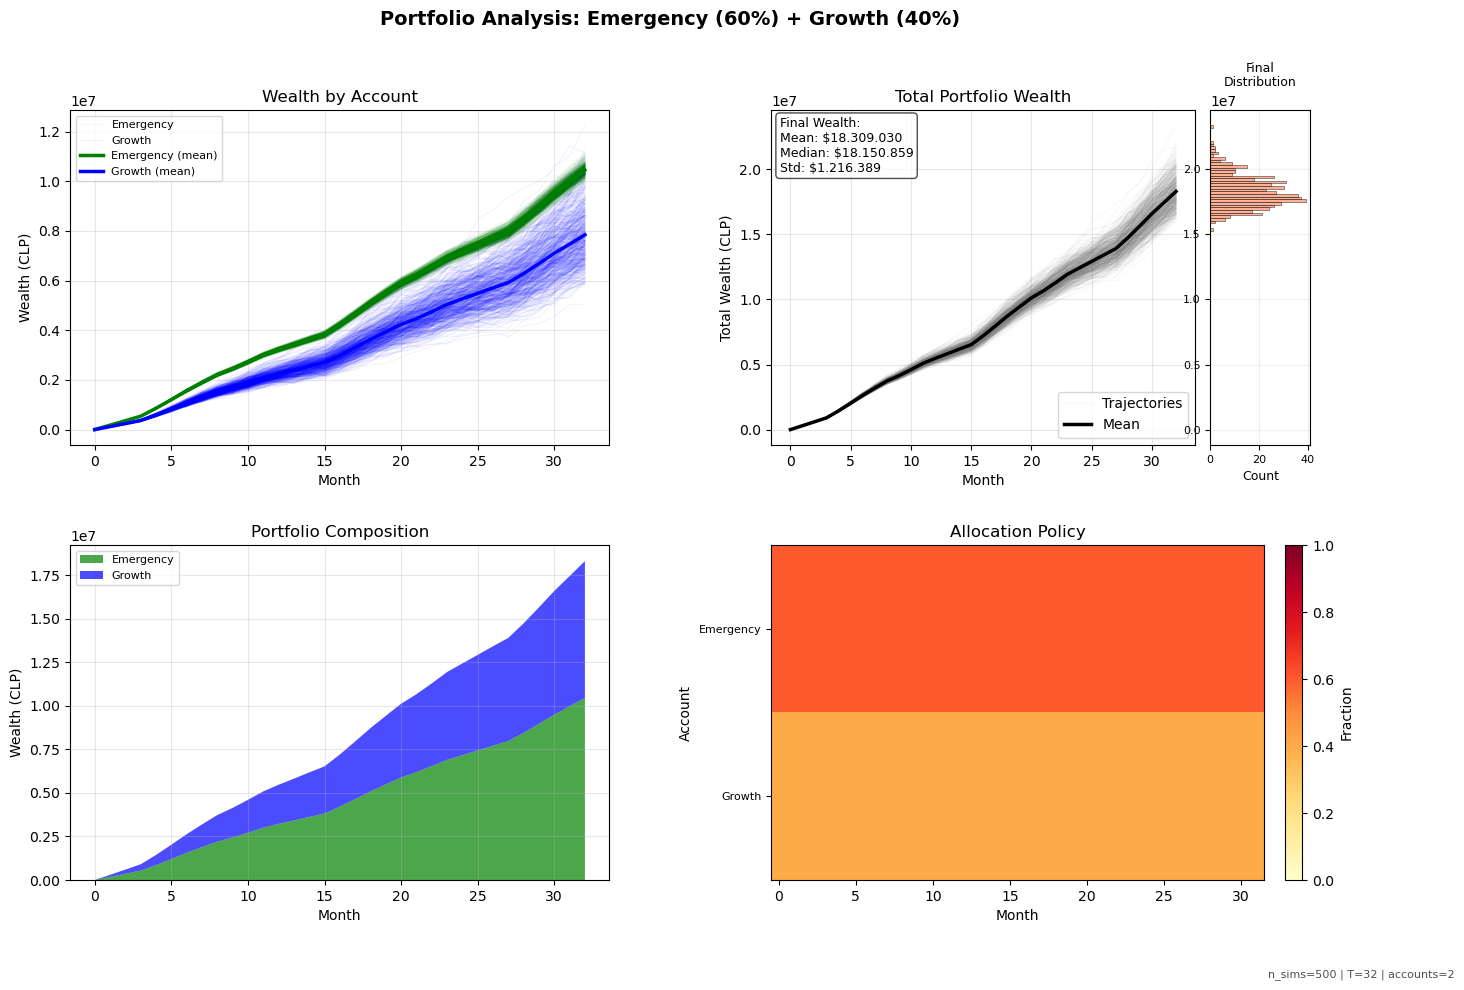

In [20]:
# ============================================================================
# Visualize Portfolio Dynamics
# ============================================================================

fig, axes_dict = portfolio.plot(
    result=result,
    X=X,
    figsize=(16, 10),
    title="Portfolio Analysis: Emergency (60%) + Growth (40%)",
    show_trajectories=True,
    trajectory_alpha=0.05,
    colors={"Emergency": "green", "Growth": "blue"},
    hist_bins=40,
    hist_color='coral',
    save_path=False,
    return_fig_ax=True
)

# --- Optional: further customization ---
axes_dict['total'].set_ylabel("Total Wealth (CLP)")
fig.tight_layout()